# Concentration dependent elastic constants

Here we demonstrate the new `SQSElasticConstantsList` job, which gets elastic constants as a function of chemical composition.

This job works by using special quasirandom structures (implemented by Dominik Gehringer and Jan Janssen) to create cells with the requested chemical composition from a base crystal structure. These are then evaluated for their elastic constants (implemented by Yuri Lysogorskiy). These are fully relaxed and the basic output is the chemical composition and full 6x6 elastic matrix. (More detailed output is available from the underlying `SQSElasticConstants` job stored in HDF5, but user-friendly bindings are not currently implemented.)

These components were assembled together in a single job (implemented by Liam Huber) that takes a list of dictionaries giving the desired chemical compositions (e.g. `{'Al': 0.95, 'Mg': 0.04, '0': 0.01}` for 95% Aluminium 4% Magnesium and 1% vacancies) and three reference jobs: a `ref_ham` which says how the structures should be interpreted for forces and energies (e.g. a Lammps job with a particular potential) -- the structure of this job provides the base crystal upon which the chemical compositions are imposed -- and `ref_sqs` and `ref_elastic` which hold the input parameters for the SQS and elastic constant calculation components.

The current implementation only facilitates modal run modes and is not heavily tested. The example below takes less than 30 minutes on a single core, so for the purposes of demonstration this is not a serious limitation.

In [1]:
from pyiron import Project
import numpy as np
import matplotlib.pyplot as plt
from elastic import ElasticMatrixJob

In [2]:
pr = Project('elastic_pipeline')
pr.remove_jobs_silently(recursive=True)

This group does not exist in the HDF5 file sqs_0_005
This group does not exist in the HDF5 file sqs_0_01
This group does not exist in the HDF5 file sqs_0_015
This group does not exist in the HDF5 file sqs_0_02
This group does not exist in the HDF5 file elastic_Al500_lmp
This group does not exist in the HDF5 file elastic_Al500
This group does not exist in the HDF5 file elastic_Al498Mg2_lmp
This group does not exist in the HDF5 file elastic_Al498Mg2


## Run the calculation

Our test system will be Al with dilute Mg (up to 2%). Here we define the reference jobs, give our desired compositions.

Feedback on the most user-friendly way to take chemical composition input (while still being fully flexible in allowed compositions!) is welcome -- this code is still in development.

In [3]:
lmp_mini = pr.create_job(pr.job_type.Lammps, 'lammps_mini')
lmp_mini.structure = pr.create_ase_bulk('Al', cubic=True).repeat(5)
lmp_mini.potential = 'Al_Mg_Mendelev_eam'
lmp_mini.calc_minimize(pressure=0.0)
lmp_mini.run()

The job lammps_mini was saved and received the ID: 1


In [4]:
sqs_job_al = pr.create_job(
    job_type=pr.job_type.SQSJob, 
    job_name="sqs_job_al"
)
sqs_job_al.structure = lmp_mini.get_structure()
sqs_job_al.input['iterations'] = 1000
master_al = sqs_job_al.create_job(
    job_type=pr.job_type.SQSMaster, 
    job_name="master_al"
)

master_al.input["fraction_lst"] = [0.005, 0.01, 0.015, 0.02]
master_al.input["species_one"] = "Mg"
master_al.input["species_two"] = "Al"
master_al.run()

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_base/generic/parameters.py:860: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._dataset[col] = np.array(self._dataset[col]).tolist()


The job master_al was saved and received the ID: 2
The job sqs_0_005 was saved and received the ID: 3
Mole fractions were corrected to: {'Mg': 0.004, 'Al': 0.996}
Threads used: 1
The job sqs_0_01 was saved and received the ID: 4
Threads used: 1
The job sqs_0_015 was saved and received the ID: 5
Mole fractions were corrected to: {'Mg': 0.016, 'Al': 0.984}
Threads used: 1
The job sqs_0_02 was saved and received the ID: 6
Threads used: 1


In [5]:
concentration_lst = [0.0] + [0.005, 0.01, 0.015, 0.02]

In [6]:
structure_lst = [lmp_mini.get_structure()] + master_al.list_of_structures

In [7]:
[s.get_chemical_formula() for s in structure_lst]

['Al500', 'Al498Mg2', 'Al495Mg5', 'Al492Mg8', 'Al490Mg10']

In [8]:
for s in structure_lst:
    lmp_template = pr.create_job(pr.job_type.Lammps, 'lammps_tmp')
    lmp_template.potential = 'Al_Mg_Mendelev_eam'
    lmp_template.server.run_mode.interactive = True
    lmp_template.interactive_enforce_structure_reset = True
    lmp_template.structure = s
    elastic = lmp_template.create_job(ElasticMatrixJob, 'elastic_' + s.get_chemical_formula())
    elastic.input['num_of_points'] = 5
    elastic.input['fit_order'] = 2
    elastic.input['eps_range'] = 0.005
    elastic.input['relax_atoms'] = True
    elastic.input['sqrt_eta'] = True
    elastic.run()

The job elastic_Al500 was saved and received the ID: 7
The job elastic_Al500_lammps_tmp was saved and received the ID: 8


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron/lammps/interactive.py:363: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  "Warning: setting upper trangular matrix might slow down the calculation"


The job elastic_Al498Mg2 was saved and received the ID: 9
The job elastic_Al498Mg2_lammps_tmp was saved and received the ID: 10
The job elastic_Al495Mg5 was saved and received the ID: 11
The job elastic_Al495Mg5_lammps_tmp was saved and received the ID: 12
The job elastic_Al492Mg8 was saved and received the ID: 13
The job elastic_Al492Mg8_lammps_tmp was saved and received the ID: 14
The job elastic_Al490Mg10 was saved and received the ID: 15
The job elastic_Al490Mg10_lammps_tmp was saved and received the ID: 16


## post-processing the data

The output of the job is stored to HDF5. To verify this, and since the actual calculation may be done at a different time than the results are analyzed, we demonstrate this by loading the job.

There is also a little bit of annoying post-processing to get it all formatted as nice numpy arrays. Some of this is reasonable (like the need to explicitly add 0% Mg to the first chemistry -- we wouldn't want to list *everything that's not there*!), some is "not my fault" (like the way the InputList class mangles our chemistry dictionary on saving it to HDF), and some needs nicer helper functions in the future (like the ability to explicity ask for "C12" and get it by that string).

In [10]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,Al500,lammps_mini,/lammps_mini,/home/jovyan/,elastic_pipeline/,2020-11-04 10:20:56.593093,2020-11-04 10:20:57.277346,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1,Lammps,0.1,None,NaN
1,2,finished,Al500,master_al,/master_al,/home/jovyan/,elastic_pipeline/,2020-11-04 10:20:59.878747,2020-11-04 10:21:05.978304,6.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1#4/4,SQSMaster,0.0.1,None,NaN
2,3,finished,Al500,sqs_0_005,/sqs_0_005,/home/jovyan/,elastic_pipeline/master_al_hdf5/,2020-11-04 10:21:00.388448,2020-11-04 10:21:01.240254,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1,AtomisticGenericJob,0.1,None,2.0
3,4,finished,Al500,sqs_0_01,/sqs_0_01,/home/jovyan/,elastic_pipeline/master_al_hdf5/,2020-11-04 10:21:01.773872,2020-11-04 10:21:02.555532,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1,AtomisticGenericJob,0.1,None,2.0
4,5,finished,Al500,sqs_0_015,/sqs_0_015,/home/jovyan/,elastic_pipeline/master_al_hdf5/,2020-11-04 10:21:03.052928,2020-11-04 10:21:03.773929,0.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1,AtomisticGenericJob,0.1,None,2.0
5,6,finished,Al500,sqs_0_02,/sqs_0_02,/home/jovyan/,elastic_pipeline/master_al_hdf5/,2020-11-04 10:21:04.218881,2020-11-04 10:21:05.954557,1.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1,AtomisticGenericJob,0.1,None,2.0
6,7,finished,Al500,elastic_Al500,/elastic_Al500,/home/jovyan/,elastic_pipeline/,2020-11-04 10:21:08.692061,2020-11-04 10:21:17.717868,9.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1#0,ElasticMatrixJob,0.0.1,None,NaN
7,8,finished,Al500,elastic_Al500_lammps_tmp,/elastic_Al500_lammps_tmp,/home/jovyan/,elastic_pipeline/,2020-11-04 10:21:09.786585,2020-11-04 10:21:16.635925,6.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1,Lammps,0.1,None,7.0
8,9,finished,Al498Mg2,elastic_Al498Mg2,/elastic_Al498Mg2,/home/jovyan/,elastic_pipeline/,2020-11-04 10:21:18.127161,2020-11-04 10:21:55.254926,37.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1#0,ElasticMatrixJob,0.0.1,None,NaN
9,10,finished,Al498Mg2,elastic_Al498Mg2_lammps_tmp,/elastic_Al498Mg2_lammps_tmp,/home/jovyan/,elastic_pipeline/,2020-11-04 10:21:19.629682,2020-11-04 10:21:54.486131,34.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2ddamask-2dceiy0z9t#1,Lammps,0.1,None,9.0


In [27]:
def filter_function(job): 
    return "elastic_" in job.job_name and "lammps_tmp" not in job.job_name

In [28]:
job = pr.inspect("elastic_Al490Mg10")

In [29]:
job["output/elasticmatrix"]["C"].shape

(6, 6)

In [50]:
def get_c11(job):
    return job["output/elasticmatrix"]["C"][0,0]

def get_c12(job):
    return job["output/elasticmatrix"]["C"][0,1]

def get_c44(job):
    return job["output/elasticmatrix"]["C"][3,3]

In [51]:
table = pr.create_table()

In [52]:
table.filter_function = filter_function
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44

In [53]:
table.run()

 20%|██        | 1/5 [00:00<00:00,  8.50it/s]

The job table was saved and received the ID: 17


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]
2020-11-04 10:34:53,744 - pyiron_log - WARNING - The job table is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [54]:
df_data = table.get_dataframe()
df_data

,job_id,C11,C12,C44
0,7,110.193270,61.752630,32.746691
1,9,111.881378,62.844720,33.244999
2,11,113.130155,64.423113,34.108687
3,13,114.622923,66.207877,34.982857
4,15,115.649591,67.001151,35.574296


## Analysis

Finally, let's use numpy to make a polynomial fit of our elastic constants to alloying concentration and visualize the results.

Note: pure-Al data lines up very nicely with the pure Al elastic constants [reported on the NIST website for this potential](https://www.ctcms.nist.gov/potentials/entry/2009--Mendelev-M-I-Asta-M-Rahman-M-J-Hoyt-J-J--Al-Mg/2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1.html). I don't have a good sense for exactly what <2% Mg should be doing, but at least there are no sharp changes. Sanity check passed.

In [55]:
concentrations = np.array(concentration_lst)

In [56]:
C11_data = df_data["C11"].values
C12_data = df_data["C12"].values
C44_data = df_data["C44"].values

In [57]:
fit_degree = 2
C11_fit = np.polyfit(concentrations, C11_data, deg=fit_degree)
C12_fit = np.polyfit(concentrations, C12_data, deg=fit_degree)
C44_fit = np.polyfit(concentrations, C44_data, deg=fit_degree)
c = np.linspace(concentrations.min(), concentrations.max(), 100)  # 'Continuous' concentration

In [58]:
# p(x) = p[0] * x**deg + ... + p[deg]
print(C11_fit)
print(C12_fit)
print(C44_fit)

[-3082.54268635   334.73459368   110.21049878]
[-1117.88881775   299.56176514    61.61796387]
[562.11954996 136.61895724  32.68099851]


In [59]:
import seaborn as sns

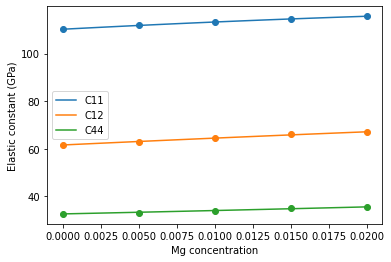

In [60]:
for color, data, fit, label in zip(
    sns.color_palette(n_colors=3), 
    [C11_data, C12_data, C44_data], 
    [C11_fit, C12_fit, C44_fit],
    ['C11', 'C12', 'C44']
):
    plt.scatter(concentrations, data, color=color)
    plt.plot(c, np.polyval(fit, c), color=color, label=label)
plt.xlabel('Mg concentration')
plt.ylabel('Elastic constant (GPa)')
plt.legend()
plt.show()

# DAMASK Simulations
The steps include, defining:
- geometries
- grains
- loading
- material properties based on the atomistically-evaluated 
- perfoming simulations

In [61]:
concentrations

array([0.   , 0.005, 0.01 , 0.015, 0.02 ])

In [ ]:
from damask import Geom
from damask import seeds
#import numpy as np
import subprocess,shlex
import os
import damask
from simulation_runner import simulation
simulation_folder =[]
job_file = []
grid = np.array([16,16,16])
size = np.array([1.0,1.0,1.0])
grains = 20
seeds = seeds.from_random(size,grains)
for i,c in enumerate(concentrations):
    simulation_folder.append('Mg-{}'.format(int(c*100)))
    os.system('mkdir {}'.format(simulation_folder[i]))
    os.system('cp Examples/material.yaml {}'.format(simulation_folder[i]))
    os.system('cp Examples/tensionX.load {}'.format(simulation_folder[i]))
    C11 = float(np.polyval(C11_fit, c))
    C12 = float(np.polyval(C12_fit, c))
    C44 = float(np.polyval(C44_fit, c))
    print(simulation_folder[i])
    os.chdir(simulation_folder[i])
    load = 'tensionX.load'
    geom_name = 'test.geom'
    material_config = 'material.yaml'
    job_file.append('{}_{}.hdf5'.format(geom_name.split('.')[0],load.split('.')[0]))
    new_geom = Geom.from_Voronoi_tessellation(grid,size,seeds)
    new_geom.save_ASCII(geom_name)
    new_geom.save(geom_name.split('.')[0])
    C_matrix = [C11*1e9,C12*1e9,C44*1e9]
    elasticity={}
    elasticity.update({'type': 'hooke'})
    elastic_constants = {'C_11': C_matrix[0], 'C_12': C_matrix[1], 'C_44': C_matrix[2]}
    elasticity.update(elastic_constants)
    mat = damask.Config.load(material_config)
    mat['phase']['Aluminum']['elasticity'] = elasticity
    mat.save(material_config)
    simulation.run(simulation_folder[i],geom_name,load)
    print('simulation {} done'.format(str(i)))
    

Mg-0


## Post-processing DAMASK simulations
- Von-Mises stress for each case is calculated
- The Stress-strain data is evaluated for each case


In [ ]:
import damask
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as PyPlot
import numpy as np
import h5py
from Plot_stress_strain import plot
from damask_eval import eval_stress , eval_strain
%matplotlib inline
d = []
stresses = []
strains = []
for i,c in enumerate(concentrations): 
    os.chdir('..')
    os.chdir(simulation_folder[i])
    d.append(damask.Result(job_file[i]))                  
    d[i].add_Cauchy()
    d[i].add_strain_tensor()
    d[i].add_Mises('sigma')
    d[i].add_Mises('epsilon_V^0.0(F)')
    d[i].add_calculation('avg_sigma',"np.average(#sigma_vM#)")
    d[i].add_calculation('avg_epsilon',"np.average(#epsilon_V^0.0(F)_vM#)")
    d[i].save_vtk(['sigma','epsilon_V^0.0(F)','sigma_vM','epsilon_V^0.0(F)_vM'])
    stresses.append(eval_stress(job_file[i]))
    strains.append(eval_strain(job_file[i]))

## Visualization
### Von-Mises Stress

In [ ]:
import pyvista as pv
inc=20
os.chdir('/home/pyiron_user/pyiron/projects/from_liam/')
os.chdir(simulation_folder[0])
mesh = pv.read(job_file[0].split('.')[0] + f'_inc{inc}.vtr')  #enter the file name you wish to view

In [ ]:
from itkwidgets import view
import itk
mesh

In [ ]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

### Stress-strain curve

In [ ]:
import matplotlib.pyplot as plt
i = 0;
stresses[0]= eval_stress(job_file[0])
stresses[1]= eval_stress(job_file[1])
stresses[2]= eval_stress(job_file[2])
colors = ['r','g','b']
#for color, strain, stress, c in zip(colors, strains, stresses, concentrations):
plt.plot(strains[0], stresses[0], 'r', linewidth=2, label = 'Mg={}%'.format(0*100))
plt.plot(strains[1], stresses[1], 'b', linestyle="None",marker = 'o' ,label = 'Mg={}%'.format(0.01*100))
plt.plot(strains[1], stresses[2], 'g', linestyle="None",marker = '*' ,label = 'Mg={}%'.format(0.01*100))
#plt.ylim(90, 95)
plt.grid(True)
plt.xlabel('$Strain$')
plt.ylabel('Stress- MPa')
plt.legend( loc='lower right')
plt.title("Stress-Strain")
 #   i= i+1;